### Install Required Libraries

In [1]:
# Ensure that the necessary libraries for TimeGPT fine-tuning are installed.
!pip install -Uqq nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.7 MB/s eta 0:00:00


### Import Required Modules

In [2]:
# Import libraries for handling data and working with the TimeGPT model.
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import userdata
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')

### Initialize Nixtla Client

In [4]:
# Initialize the Nixtla client with the API key (replace with your actual API key)
nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)

### Load and Inspect Dataset

In [5]:
# Load a time-series dataset (use your own or an example dataset)
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
print("Dataset Preview:")
print(df.head())

Dataset Preview:
  unique_id                   ds      y
0        BE  2016-10-22 00:00:00  70.00
1        BE  2016-10-22 01:00:00  37.10
2        BE  2016-10-22 02:00:00  37.10
3        BE  2016-10-22 03:00:00  44.75
4        BE  2016-10-22 04:00:00  37.10


### Fine-tune Model

In [7]:
# Fine-tune the model with a specified number of iterations and optional depth
fine_tune_steps = 10  # Number of training iterations
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df,
    h=12,  # Forecast horizon
    finetune_steps=fine_tune_steps,
    time_col='ds',
    target_col='y'
)

### Plot Forecast Results

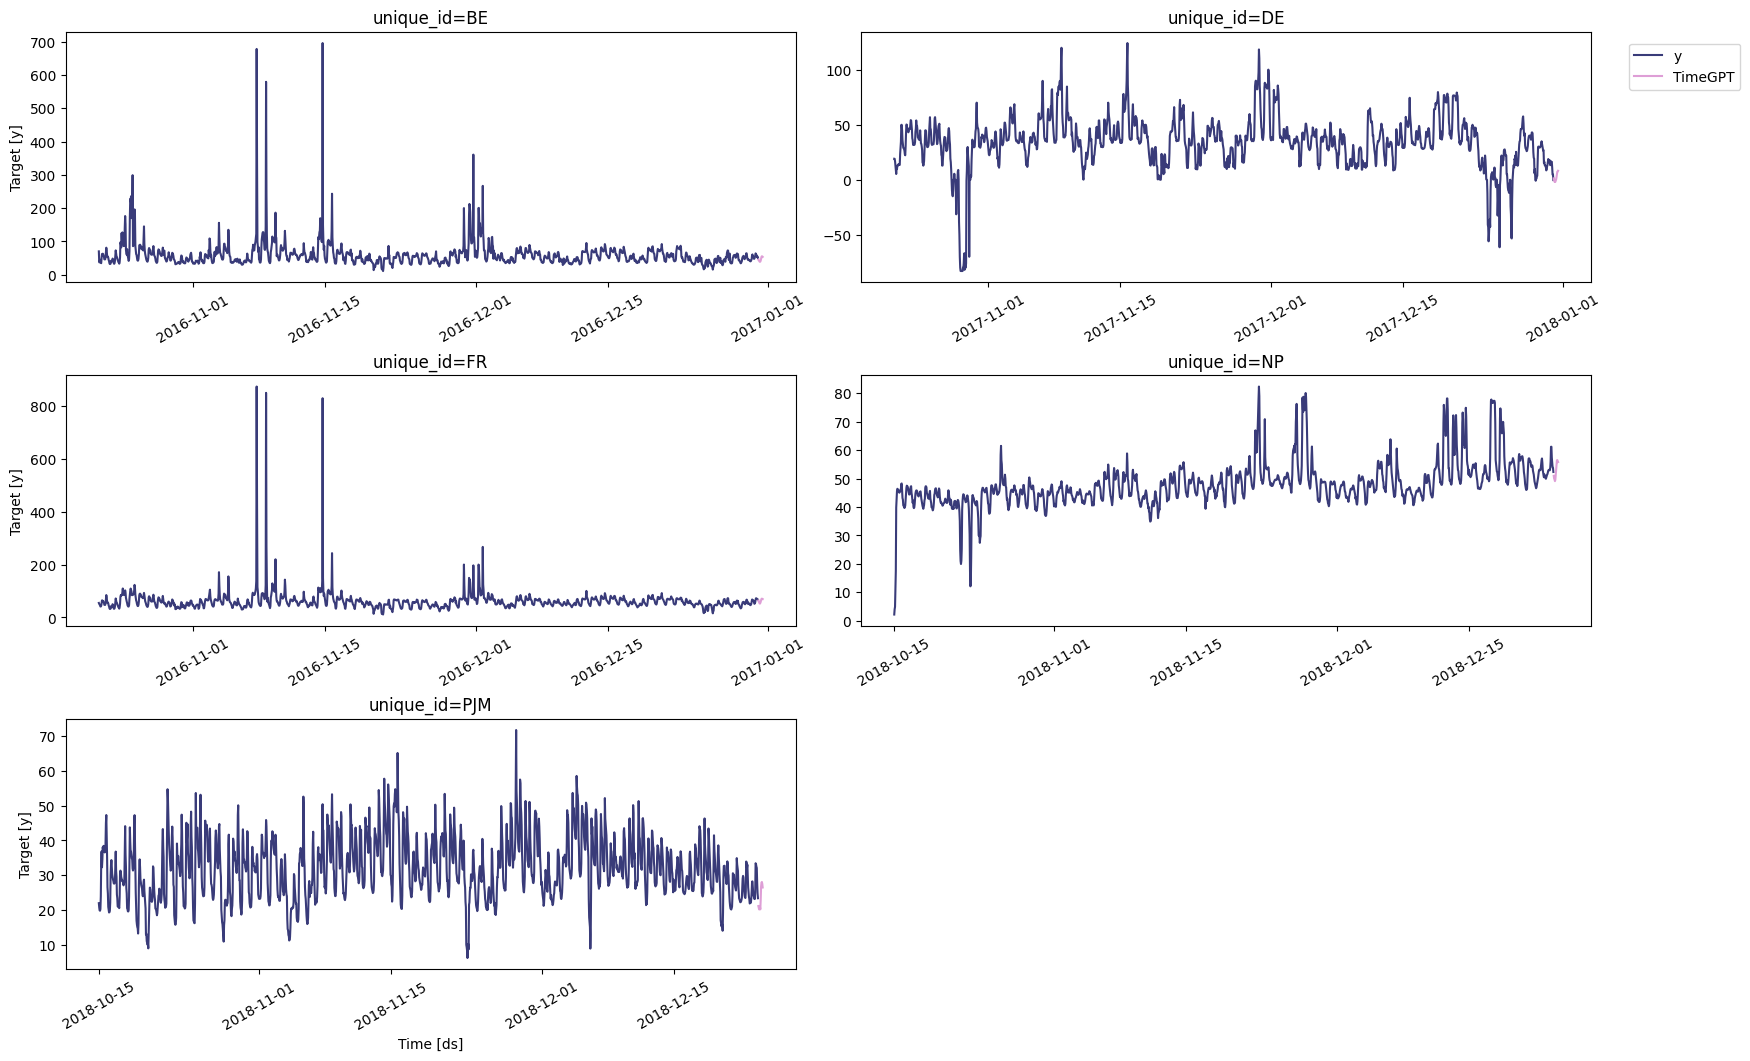

In [9]:
# Visualize the original data and fine-tuned forecast
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='ds', target_col='y'
)

### Experiment with Fine-tuning Depth

In [12]:
# Fine-tune the model at different levels of parameter adjustment to evaluate performance
train = df[:-120]
test = df[-120:].copy()
depths = [1, 2, 3, 4, 5]

for depth in depths:
    preds_df = nixtla_client.forecast(
        df=train,
        h=24,
        finetune_steps=5,
        time_col='ds',
        target_col='y'
    )
    preds = preds_df['TimeGPT'].values
    test[f'TimeGPT_depth{depth}'] = preds

In [13]:
# Add a unique identifier column for evaluation
test['unique_id'] = 0

### Evaluate Model Performance

In [15]:
# Evaluate and display performance metrics
evaluation = evaluate(test, metrics=[mae, mse], time_col="ds", target_col="y")
print("Evaluation Results:")
print(evaluation)

Evaluation Results:
   unique_id metric  TimeGPT_depth1  TimeGPT_depth2  TimeGPT_depth3  \
0          0    mae       22.252665       22.252665       22.252665   
1          0    mse      618.691619      618.691619      618.691619   

   TimeGPT_depth4  TimeGPT_depth5  
0       22.252665       22.252665  
1      618.691619      618.691619  
